<a href="https://colab.research.google.com/github/aligtr/ml/blob/master/Lab3_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#настройка среды

In [104]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

#загрузка данных 

In [105]:
URL = 'https://raw.githubusercontent.com/KaiL4eK/ml_edu/master/datasets/Titanic_train.csv'
df = pd.read_csv(URL)

#базовый анализ данных

In [106]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Составляет список признаков для обработки
categorical_features = ['Sex', 'Embarked']
numeric_features = ['Age', 'Fare']

# Создаем обработчик категориальных признаков
categorical_transformer = Pipeline(
    steps=[
        ('imp', SimpleImputer(strategy='most_frequent')),
        ('enc', OneHotEncoder(handle_unknown='error')),                   
])

# Численные значения имеют пропуски, заполним стратегией медианы
numeric_transformer = SimpleImputer(strategy='median')

# Создаем конечный конвертер, который будет использован для 
#   предобработки
preprocessor = ColumnTransformer(
    # Список конвертеров, каждый кортеж содержит
    #   имя, конвертер и признаки, на которые он будет применен
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ],
    # Признаки, не указанные ни в одном из конвертеров будут удалены
    remainder='drop'
)

preprocessor.fit(df)

X_data = preprocessor.transform(df)
print(type(X_data))
print(X_data)

<class 'numpy.ndarray'>
[[ 0.      1.      0.     ...  1.     22.      7.25  ]
 [ 1.      0.      1.     ...  0.     38.     71.2833]
 [ 1.      0.      0.     ...  1.     26.      7.925 ]
 ...
 [ 1.      0.      0.     ...  1.     28.     23.45  ]
 [ 0.      1.      1.     ...  0.     26.     30.    ]
 [ 0.      1.      0.     ...  0.     32.      7.75  ]]


#разбиение на обучающую/тестовую выборки

In [107]:
from sklearn.model_selection import train_test_split

TRAIN_RATIO = 0.8

y_data = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, 
    train_size=TRAIN_RATIO, 
    random_state=RANDOM_STATE,
    stratify=y_data
)

#функции оценки моделей

In [108]:

from sklearn.metrics import f1_score


#оценка важности признаков

In [109]:
def show_importance(model, feature_names, X):
    importances = model.feature_importances_
    for feat_imp, feat_name in zip(importances, feature_names):
        print(f'Feature: {feat_name} | {feat_imp}')

    indices = np.argsort(importances)[::-1]
    sorted_feat_names = [feature_names[ind] for ind in indices]

    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="b", align="center")
    plt.xticks(range(X.shape[1]), sorted_feat_names, rotation=70)
    plt.xlim([-1, X.shape[1]])
    plt.show()

# модели без нормалзации

модель дерева

f1_score=0.7272727272727272
Feature: Sex_female | 0.0
Feature: Sex_male | 0.5122245084814832
Feature: Embarked_C | 0.0016700945311816785
Feature: Embarked_Q | 0.006671329230365174
Feature: Embarked_S | 0.0
Feature: Age | 0.19285645099632337
Feature: Fare | 0.28657761676064675


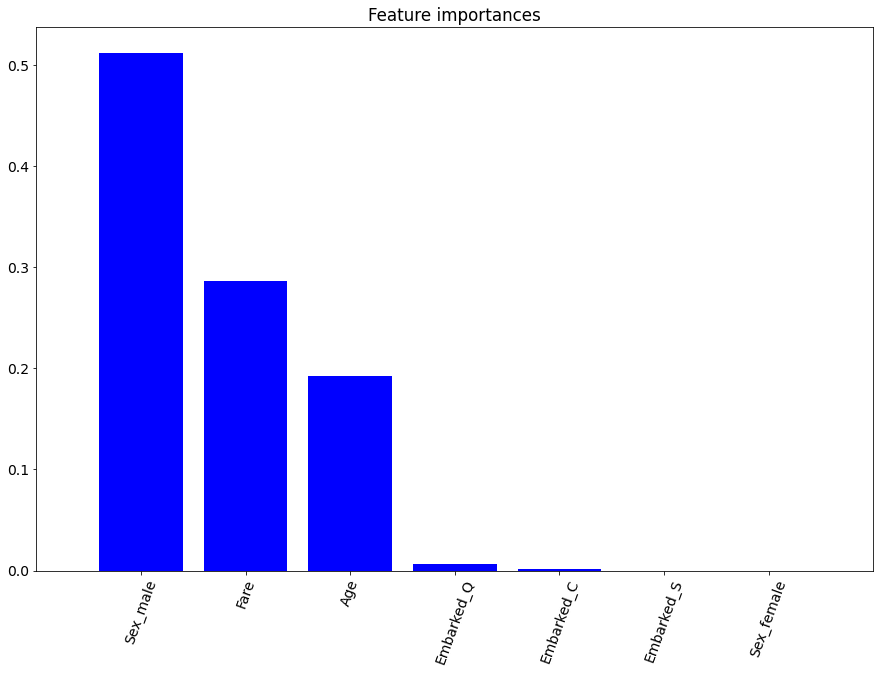

In [110]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

tree = DecisionTreeClassifier(random_state=42,max_depth=7,criterion='gini')
tree.fit(X_train, y_train)
y_pred=tree.predict(X_test)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
ohe_column_names = preprocessor \
    .named_transformers_['cat'] \
    .named_steps['enc'] \
    .get_feature_names(categorical_features)

recovered_feat_names = \
    list(ohe_column_names) + \
    list(numeric_features)
show_importance(tree, recovered_feat_names, X_train)

модель линейной регрессии

In [111]:
from sklearn.linear_model import LinearRegression

# Создаем объект
reg = LinearRegression()
# Обучаем на выборке для обучения
reg.fit(X_train, y_train)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')

f1_score=0.7272727272727272


#модели с нормализацией

In [112]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
reg = LinearRegression()
# "Обучение" трансформера - определение параметров средних и отклонений
scaler.fit(X_train)

# Стандартизация данных
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

модель дерева

f1_score=0.7272727272727272
Feature: Sex_female | 0.0
Feature: Sex_male | 0.5122245084814832
Feature: Embarked_C | 0.0016700945311816785
Feature: Embarked_Q | 0.006671329230365174
Feature: Embarked_S | 0.0
Feature: Age | 0.19285645099632337
Feature: Fare | 0.28657761676064675


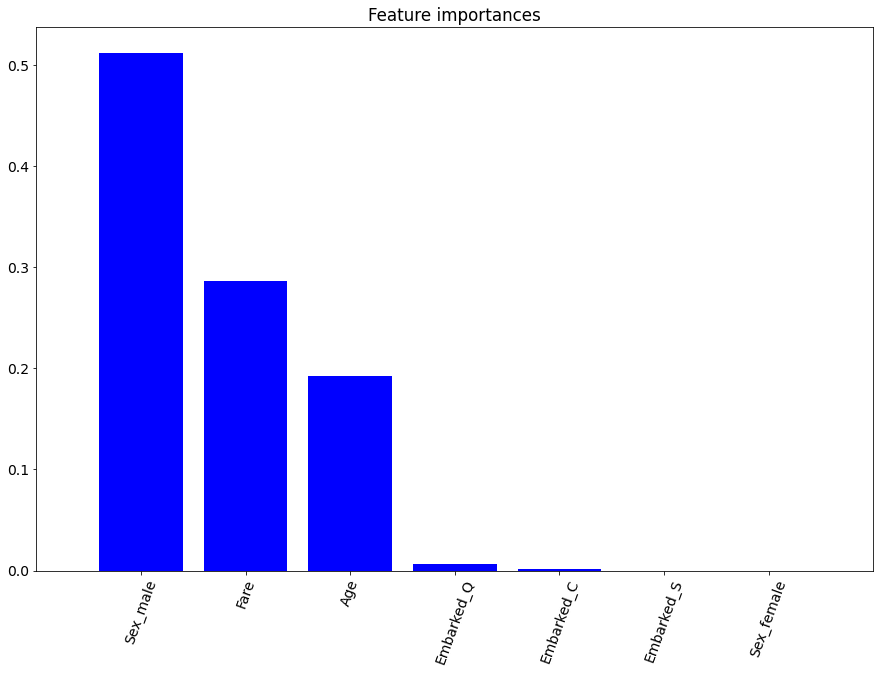

In [113]:
tree = DecisionTreeClassifier(random_state=42,max_depth=7,criterion='gini')
tree.fit(X_train_scaled, y_train)
y_pred=tree.predict(X_test_scaled)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
show_importance(tree, recovered_feat_names, X_train_scaled)

модель линейной регрессиии

In [114]:
# Создаем объект
reg = LinearRegression()
# Обучаем на выборке для обучения
reg.fit(X_train_scaled, y_train)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')

f1_score=0.7272727272727272


In [115]:
from sklearn.model_selection import cross_val_score
f1_scores=np.ndarray([14,2])
criterions={"gini", "entropy"}
max_depths=np.array(range(1,15,1))
for i, max_depth in enumerate(max_depths):
  for j, criterion in enumerate(criterions):
    tree = DecisionTreeClassifier(random_state=42,max_depth=max_depth,criterion=criterion)
    scores = cross_val_score(
      tree,     # Модель для оценки
      X_data,          # Данные для обучения
      y_data,          # Разметка для обучения
      cv=5,       # Количество фолдов
      scoring='f1_macro'  # Желаемая метрика
    )
    f1_scores[i,j]=scores.mean();
table=pd.DataFrame(data=f1_scores,columns=criterions,index=max_depths)
table

,gini,entropy
1,0.770358,0.770358
2,0.770635,0.770635
3,0.765359,0.766562
4,0.775015,0.777137
5,0.779150,0.778704
6,0.774637,0.777148
7,0.784154,0.773229
8,0.752837,0.765391
9,0.754481,0.760618
10,0.747951,0.751778


#модель леса

f1_score=0.6976744186046512
Feature: Sex_female | 0.22296956265752643
Feature: Sex_male | 0.23035381074699393
Feature: Embarked_C | 0.01826651304750619
Feature: Embarked_Q | 0.006931990535342987
Feature: Embarked_S | 0.018315563648138303
Feature: Age | 0.21192756025028747
Feature: Fare | 0.2912349991142046


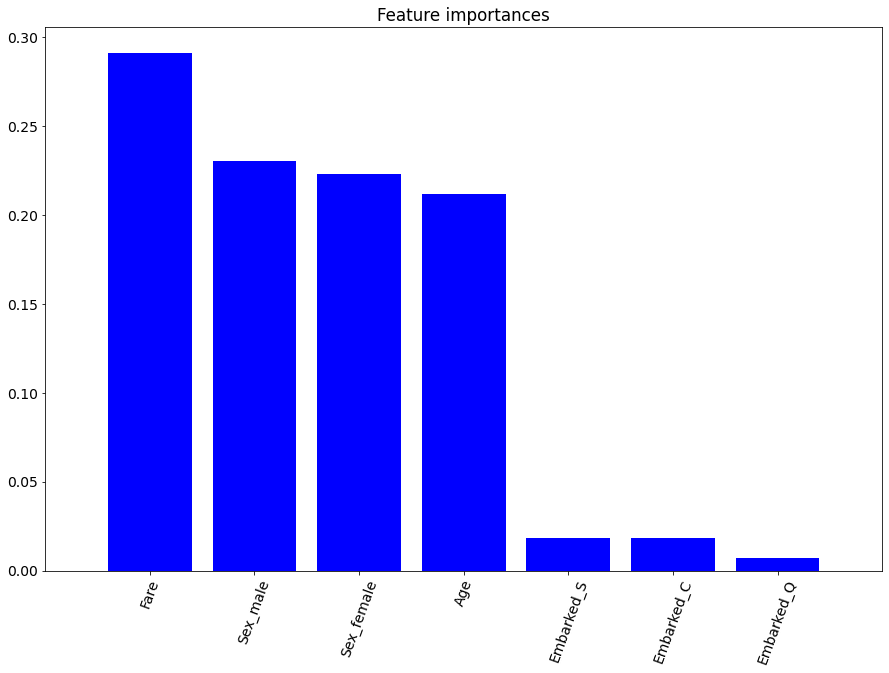

In [116]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=7,criterion='gini')
rf_clf.fit(X_train_scaled, y_train)
y_pred=rf_clf.predict(X_test_scaled)
f1 = f1_score(y_test,y_pred)
print(f'f1_score={f1}')
show_importance(rf_clf, recovered_feat_names, X_train)